In [1]:
from portfolio_optimization.data_processing import *
from portfolio_optimization.data_collection import *
from datetime import datetime, timezone, timedelta
from tokens.get_assets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, plotting

In [2]:
asset_list = get_tickers()
_df = get_historical_prices_for_assets(asset_list['high_risk_tickers'], time_range=timedelta(days=365 * 3), interested_columns=["ReferenceRate", "CapMrktEstUSD"])

# Filter out all columns containing `_` in their name
df = _df.loc[:, ~_df.columns.str.contains("_")]

# Get all the market caps
mcaps = _df.loc[:, _df.columns.str.contains("CapMrktEstUSD")]
mcaps.columns = mcaps.columns.str.replace("_CapMrktEstUSD", "")
mcaps.replace(np.nan, 0, inplace=True)
# Print comprehensive statistical summary
df

High risk tickers: 12
Medium risk tickers: 60
Low risk tickers: 8


/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/data_collection/get_crypto_price_range.py:41: DtypeWarning: Columns (146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/d2/1qh2h9ys19z3375prb_0cb8w0000gn/T/ipykernel_78758/3080830945.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcaps.replace(np.nan, 0, inplace=True)


,btc,ada,link,eth,cake,bnb,uni,dot,aave,matic,sol,avax
2020-11-01,13807.233611,0.092948,11.232365,386.585236,NaN,28.403506,2.265180,4.187161,29.670539,0.013716,1.543335,3.636919
2020-11-02,13736.899411,0.098006,11.555447,395.577783,NaN,28.387124,2.380215,4.211840,30.679240,0.014151,1.605117,3.685878
2020-11-03,13595.564760,0.092652,10.825619,383.848317,NaN,27.917180,2.260588,4.025543,29.683016,0.013736,1.478196,3.623290
2020-11-04,13996.915399,0.093643,10.435877,388.548200,NaN,26.905051,2.138067,4.020843,27.998696,0.012661,1.420223,3.315037
2020-11-05,14129.148195,0.095578,10.463831,401.795614,NaN,26.851270,1.923606,4.085757,27.768951,0.012207,1.395348,3.173110
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-28,33896.938528,0.289180,11.180541,1780.846738,1.223446,224.427144,4.024729,4.136491,78.404583,0.609436,31.751250,10.579189
2023-10-29,34091.589033,0.290944,10.913480,1776.209957,1.230474,225.631967,4.079577,4.176822,80.047840,0.620221,31.610382,10.957315
2023-10-30,34574.337721,0.295684,11.124579,1797.719451,1.240724,227.270141,4.163477,4.319113,84.697121,0.639293,32.834051,11.371950
2023-10-31,34495.105021,0.302730,11.219667,1809.385648,1.247507,228.226036,4.175362,4.520510,83.764038,0.649830,34.928024,11.444085


,btc,ada,link,eth,cake,bnb,uni,dot,aave,matic,sol,avax
btc,1.000000,0.802168,0.860118,0.805326,0.776238,0.654914,0.835278,0.936273,0.819098,0.398296,0.646225,0.653902
ada,0.802168,1.000000,0.800250,0.819158,0.863663,0.704316,0.836023,0.855084,0.810858,0.572985,0.707478,0.590506
link,0.860118,0.800250,1.000000,0.621901,0.935083,0.507670,0.940751,0.922180,0.942434,0.244804,0.447888,0.436145
eth,0.805326,0.819158,0.621901,1.000000,0.666188,0.879777,0.620706,0.765154,0.584350,0.796873,0.886099,0.827546
cake,0.776238,0.863663,0.935083,0.666188,1.000000,0.747956,0.944084,0.847676,0.929834,0.324492,0.444943,0.362828
bnb,0.654914,0.704316,0.507670,0.879777,0.747956,1.000000,0.586856,0.664841,0.473168,0.798236,0.745699,0.718873
uni,0.835278,0.836023,0.940751,0.620706,0.944084,0.586856,1.000000,0.897904,0.955351,0.282524,0.395754,0.358735
dot,0.936273,0.855084,0.922180,0.765154,0.847676,0.664841,0.897904,1.000000,0.871658,0.404691,0.662701,0.637094
aave,0.819098,0.810858,0.942434,0.584350,0.929834,0.473168,0.955351,0.871658,1.000000,0.232772,0.356188,0.358214
matic,0.398296,0.572985,0.244804,0.796873,0.324492,0.798236,0.282524,0.404691,0.232772,1.000000,0.755995,0.738774


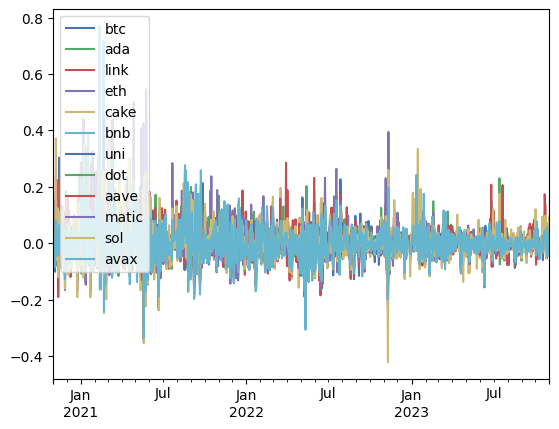

In [3]:
# this will give you the percentage change
df_percentage_variation = df.pct_change()

# plot variation of each asset's price
df_percentage_variation.plot()
pd.DataFrame(df).corr()

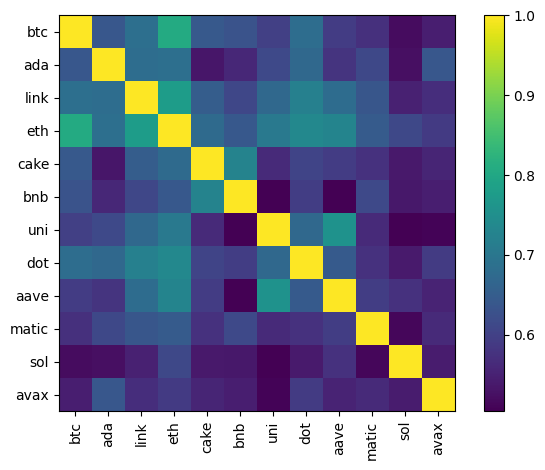

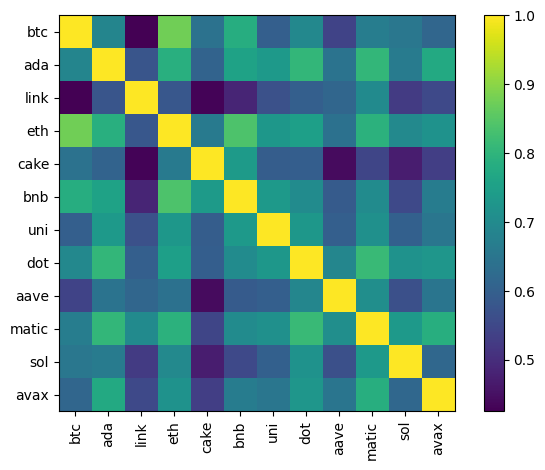

In [4]:
past_df, future_df = df.iloc[:-100], df.iloc[-100:]
future_cov = risk_models.sample_cov(future_df).fillna(0)
sample_cov = risk_models.sample_cov(past_df).fillna(0)

plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

In [5]:
rets = expected_returns(df)
rets.tail()

,btc,ada,link,eth,cake,bnb,uni,dot,aave,matic,sol,avax
2023-10-28,-0.008325,0.005679,0.019138,-0.013170,0.010573,0.005262,-0.020180,-0.023541,-0.030388,-0.036109,-0.032973,-0.046408
2023-10-29,0.005742,0.006100,-0.023886,-0.002604,0.005744,0.005368,0.013628,0.009750,0.020959,0.017698,-0.004437,0.035742
2023-10-30,0.014160,0.016290,0.019343,0.012110,0.008330,0.007260,0.020566,0.034067,0.058081,0.030749,0.038711,0.037841
2023-10-31,-0.002292,0.023828,0.008548,0.006489,0.005467,0.004206,0.002855,0.046629,-0.011017,0.016482,0.063774,0.006343
2023-11-01,0.004097,-0.033724,0.009765,0.002297,-0.011110,-0.008475,-0.007295,-0.016678,-0.029930,-0.022508,0.095195,-0.012950


In [6]:
# exp_cov = risk_models.exp_cov(past_df)
# plotting.plot_covariance(exp_cov, plot_correlation=True)
# plotting.plot_covariance(future_cov, plot_correlation=True)
# plt.show()

Optimization
================

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/black_litterman.py:158: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


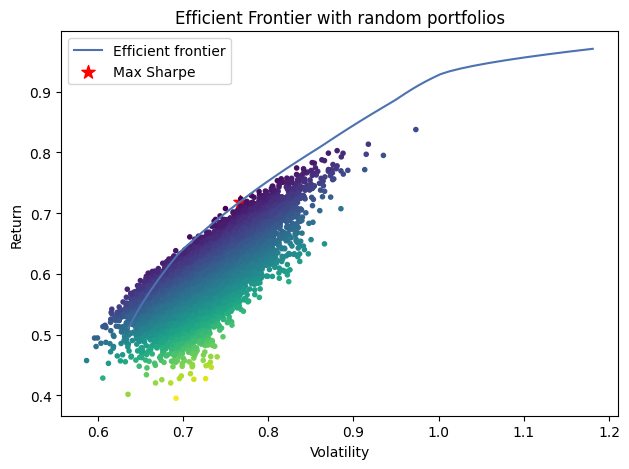

In [7]:
from portfolio_optimization.optimization.hrp import HRPOptimization
from portfolio_optimization.optimization.markowitz import Markowitz
from portfolio_optimization.optimization.black_litterman import BlackLitterman
from portfolio_optimization.optimization.risk_parity import RiskParity
from portfolio_optimization.optimization.heuristic import FastRiskParity, Heuristic, RewardToRisk, VolatilityOfVolatility, ValueAtRisk, RewardToVaR, Combination, SimpleVolatility
hrp = HRPOptimization(df, rets=rets)
hrp_weights = hrp.get_weights()

markowitz = Markowitz(df)
markowitz_weights = markowitz.get_weights()

last_mcaps = mcaps.iloc[-2]

bl = BlackLitterman(df, mcaps=last_mcaps)
bl_weights = bl.get_weights()
bl.plot_frontier()

rp = RiskParity(df)
rp_weights = rp.get_weights()

fast_rp = FastRiskParity(df)
fast_rp_weights = fast_rp.get_weights()

rtr = RewardToRisk(df)
rtr_weights = rtr.get_weights()

vov = VolatilityOfVolatility(df)
vov_weights = vov.get_weights()

vo = SimpleVolatility(df)
vo_weights = vo.get_weights()

var = ValueAtRisk(df)
var_weights = var.get_weights()

rtvar = RewardToVaR(df)
rtvar_weights = rtvar.get_weights()

combination = Combination(df)
combination_weights = combination.get_weights()

heuristic = Heuristic(df)
heuristic_weights = heuristic.get_weights()

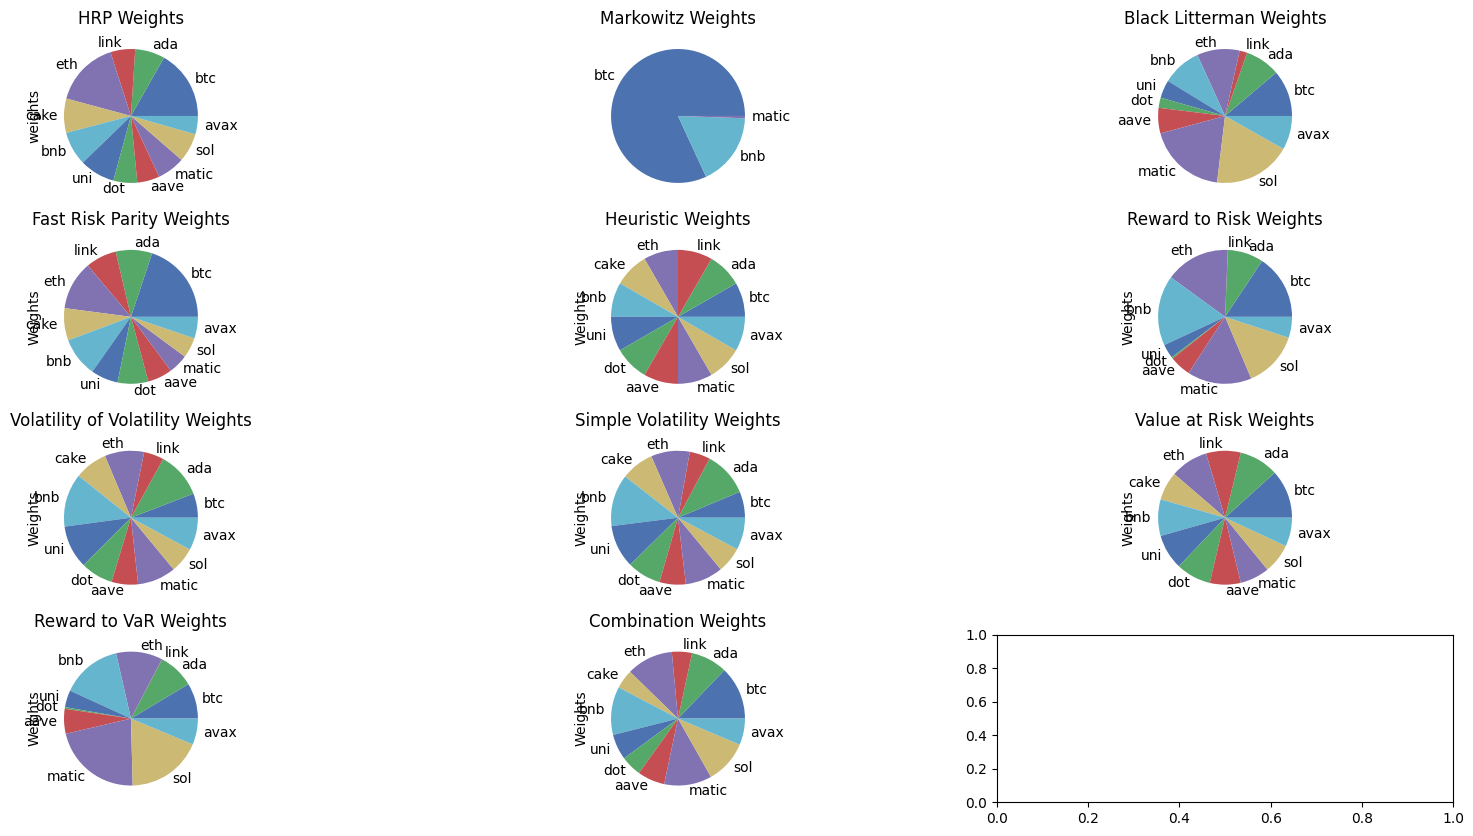

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

pd.Series(hrp_weights).plot.pie(ax=axs[0][0]);
axs[0][0].set_title('HRP Weights')

pd.Series(markowitz_weights).plot.pie(ax=axs[0][1]);
axs[0][1].set_title('Markowitz Weights')

pd.Series(bl_weights).plot.pie(ax=axs[0][2]);
axs[0][2].set_title('Black Litterman Weights')

pd.Series(fast_rp_weights).plot.pie(ax=axs[1][0]);
axs[1][0].set_title('Fast Risk Parity Weights')

pd.Series(heuristic_weights).plot.pie(ax=axs[1][1]);
axs[1][1].set_title('Heuristic Weights')

pd.Series(rtr_weights).plot.pie(ax=axs[1][2]);
axs[1][2].set_title('Reward to Risk Weights')

pd.Series(vov_weights).plot.pie(ax=axs[2][0]);
axs[2][0].set_title('Volatility of Volatility Weights')

pd.Series(vo_weights).plot.pie(ax=axs[2][1]);
axs[2][1].set_title('Simple Volatility Weights')

pd.Series(var_weights).plot.pie(ax=axs[2][2]);
axs[2][2].set_title('Value at Risk Weights')

pd.Series(rtvar_weights).plot.pie(ax=axs[3][0]);
axs[3][0].set_title('Reward to VaR Weights')

pd.Series(combination_weights).plot.pie(ax=axs[3][1]);
axs[3][1].set_title('Combination Weights')


plt.show()

/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/markowitz.py:158: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


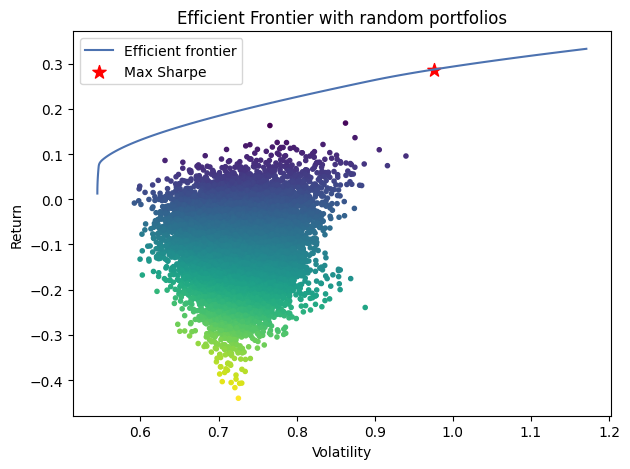

In [9]:
markowitz.plot_frontier()

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional o

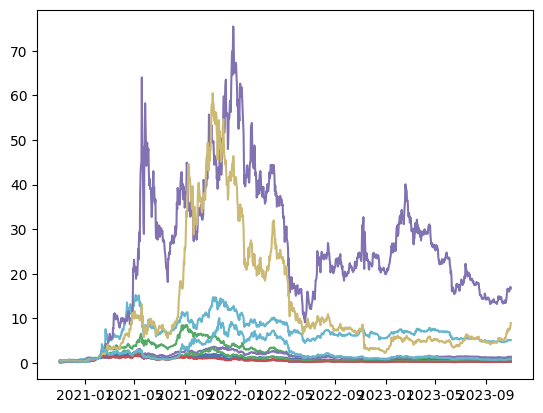

In [11]:
from portfolio_optimization.portfolio.Portfolio import Portfolio
from portfolio_optimization.backtesting.Backtesting import Backtest
from dateutil.relativedelta import relativedelta

# The portfolio starts
start_date_portfolio = df.index[0] + relativedelta(months=3)

initial_bid = 1000

porfolio_hrp = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=HRPOptimization,
)

portfolio_markowitz = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Markowitz,
)

portfolio_bl = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=BlackLitterman,
    mcaps=mcaps.loc[start_date_portfolio],
)

portfolio_parity = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RiskParity,
)

portfolio_fast_parity = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=FastRiskParity,
)

portfolio_default = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Heuristic,
)

portfolio_rtr = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RewardToRisk,
)

portfolio_vov = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=VolatilityOfVolatility,
)

portfolio_vo = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=SimpleVolatility,
)

portfolio_var = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=ValueAtRisk,
)

portfolio_rvar = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RewardToVaR,
)

portfolio_combination = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Combination,
)

backtest = Backtest(
    portfolios={
        "HRP": porfolio_hrp,
        "Markowitz": portfolio_markowitz,
        "BL": portfolio_bl,
        "Risk Parity": portfolio_parity,
        "Fast Risk Parity": portfolio_fast_parity,
        "Heuristic": portfolio_default,
        "Reward to Risk": portfolio_rtr,
        "Volatility of Volatility": portfolio_vov,
        "Simple Volatility": portfolio_vo,
        "Value At Risk": portfolio_var,
        "Reward to VaR": portfolio_rvar,
        "Combination": portfolio_combination,
    },
    start_date=start_date_portfolio,
    end_date=df.index[-1],
    rebalance_frequency="1W",
    data=df,
    mcaps=mcaps,
)

perfs = backtest.run_backtest(look_back_period=120, look_back_unit="D")

# Plot portfolio value over time using matplotlib
import matplotlib.pyplot as plt

df_normalized = df / df.loc[start_date_portfolio]
plt.plot(df_normalized)


In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import GridBox 

# Calculate the first date of the portfolio. The start date is the minimum date of the portfolio_value DataFrame within the `perfs` object. So we just reduce the perfs object to the portfolio_value DataFrame, and then get the minimum date.
start_date_portfolio = min(performance.portfolio_value['Portfolio Value'].index.min() for performance in perfs)


# Normalize prices of each asset at the start date of the portfolio
df_normalized = df / df.loc[start_date_portfolio]

# Calculate the daily equal-weighted return  
# df['equal_weighted'] = df_normalized.mean(axis=1)

# Normalize our portfolio and equally-weighted series to 100 at the start date of the portfolio
portfolio_normalized = pd.concat({performance.name: performance.portfolio_value['Portfolio Value'].loc[start_date_portfolio:] for performance in perfs}, axis=1)

# convert the index to a list of dates, which will be used for the Slider
_dates = [date for performance in perfs for date in performance.portfolio_value['Portfolio Value'].index]
dates = list(dict.fromkeys(_dates))
_rebalance_dates = [rebalance_date for performance in perfs for rebalance_date in performance.rebalance_dates if rebalance_date >= start_date_portfolio]
rebalance_dates = list(dict.fromkeys(_rebalance_dates))

In [13]:
# create a function to update the chart
def update(rebalance_date_index, main_portfolio=0):
    clear_output(wait=True)
        
    selected_date = rebalance_dates[rebalance_date_index]
    
    # Adjust the date_index to the closest rebalance date
    date_index = dates.index(selected_date)
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[1, 0]) # for you normalized performance comparison
    ax3 = plt.subplot(gs[0, 0]) # put the ax1 graph below
    ax4 = plt.subplot(gs[:, 1]) # add a new bar graph showing the backtest.portfolio_holdings on the left of ax2
    ax2 = plt.subplot(gs[0, 1]) # for your pie chart of portfolio composition

    # plot portfolio values on ax1
    portfolio_names = list(p.name for p in perfs)
    ax1.plot(portfolio_normalized.index, portfolio_normalized, label=portfolio_names)
    
    for rebalance_date in rebalance_dates:
        if rebalance_date >= start_date_portfolio:
            ax1.axvline(x=rebalance_date, color='gray', linestyle='--')  

    ax1.axvline(x=selected_date, color='blue', linestyle='-')  # the selected date bar

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Normalized Value")
    ax1.legend()
    ax1.set_title("Performance comparison (selected blue line)")

    # create portfolio composition pie chart on ax2
    selected = perfs[main_portfolio].portfolio_compositions.iloc[rebalance_date_index]
    # filter out rows where value is 0
    selected = selected[selected != 0]

    labels = selected.keys().tolist()
    sizes = selected.replace(np.nan, 0).tolist()

    ax2.pie(sizes, labels=labels)
    ax2.set_title(str(dates[date_index]))

    portfolio_value = perfs[main_portfolio].portfolio_holdings.iloc[rebalance_date_index] * df.loc[selected_date]


    # plot portfolio_value instead of portfolio_holdings
    portfolio_value.plot(ax=ax3, kind='bar')
    ax3.set_title('Portfolio Value in Dollars')

    plt.show()

# create a slider for dates
date_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(rebalance_dates)-1 if len(rebalance_dates) > 0 else 0,
    step=1,
    description='Date Index:',
    continuous_update=True
)

pf_index = widgets.Dropdown(
    options=[(p.name, i) for i, p in enumerate(perfs)],
    value=0,
    description='Portfolio:',
    disabled=False,
)


# link the date_slider to the update function
widgets.interactive(update, rebalance_date_index=date_slider, main_portfolio=pf_index)

interactive(children=(IntSlider(value=0, description='Date Index:', max=142), Dropdown(description='Portfolio:…

# Portfolio Rating
> Using Sharpe ratio to evaluate the performance of a portfolio

In [14]:
returns = portfolio_normalized.pct_change().apply(lambda x: np.log(1+x))


mean_returns = returns.mean()
std_returns = returns.std()

# Assume a risk free rate of 0.01, though this could be any risk free rate of your choice
risk_free_rate = 0.054

#  Calculate the Sharpe Ratio for each asset
sharpe_ratios = (mean_returns - risk_free_rate) / std_returns

# Sort the assets by their sharpe ratios
ranked_assets = sharpe_ratios.sort_values(ascending=False)

ranked_assets

Markowitz                  -1.052206
Reward to VaR              -1.113120
BL                         -1.173572
Heuristic                  -1.176072
Reward to Risk             -1.178147
Simple Volatility          -1.189270
Volatility of Volatility   -1.189807
Combination                -1.194873
Value At Risk              -1.207408
Risk Parity                -1.218206
HRP                        -1.266903
Fast Risk Parity           -1.277781
dtype: float64

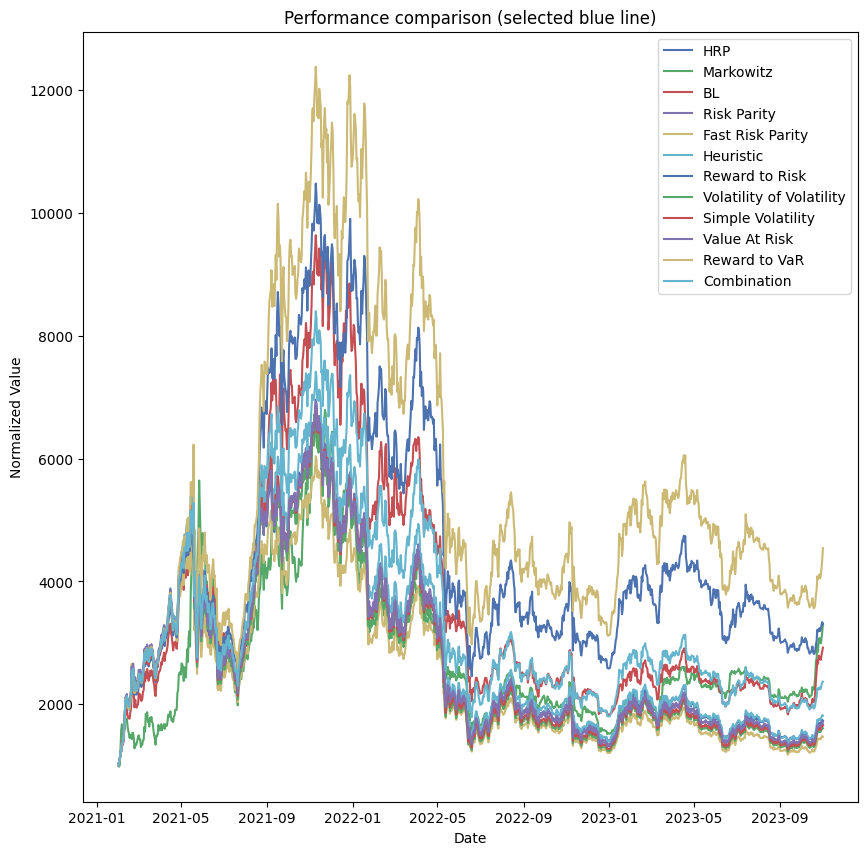

In [15]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111, ylabel="Portfolio value in $")

# plot portfolio values on ax1
portfolio_names = list(p.name for p in perfs)
ax1.plot(portfolio_normalized.index, portfolio_normalized, label=portfolio_names)
ax1.set_xlabel("Date")
ax1.set_ylabel("Normalized Value")
ax1.legend()
ax1.set_title("Performance comparison (selected blue line)")
# Save as PDF
plt.savefig(f"./out/{backtest.rebalance_frequency}/portfolio_value.pdf", bbox_inches="tight")

In [ ]:
df_normalized.to_excel('~/Downloads/df_normalized.xlsx', index=False)